In [ ]:
!pip install alpaca_trade_api

In [ ]:
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import REST, TimeFrame
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier

#import 

In [ ]:
alpaca = tradeapi.REST('PKEK13ZV89MV6G9JVS76','HoWeAjGDcmOyv8ogQMz7NHueC7j5K6rj0qJgaN4G', base_url = 'https://paper-api.alpaca.markets')
btc = alpaca.get_crypto_bars('BTCUSD',TimeFrame.Hour, '2020-06-25','2022-06-25').df
btc = btc.reset_index()
btc = btc[btc['exchange'] == 'FTXU']
btc['differece'] = btc['close'].diff()
btc.drop(1, axis = 0, inplace = True)
btc['prevmvt'] = np.where((btc['differece'] > 0), 1, 0)
# btc['prevmvt'] = np.where((btc['differece'] < -50), 1, btc['prevmvt'])
# btc['prevmvt'] = np.where((btc['differece'] < -100), 2, btc['prevmvt'])
# btc['prevmvt'] = np.where((btc['differece'] < -150), 3, btc['prevmvt'])

# btc['prevmvt'] = np.where((btc['differece'] > 0), 4, btc['prevmvt'])
# btc['prevmvt'] = np.where((btc['differece']  > 50), 5, btc['prevmvt'])
# btc['prevmvt'] = np.where((btc['differece']  > 100), 6, btc['prevmvt'])
# btc['prevmvt'] = np.where((btc['differece'] > 150), 7, btc['prevmvt'])
btc['target'] = btc['prevmvt'].shift(-1)
btc.drop(39769, axis = 0, inplace = True)
dates = pd.to_datetime(btc['timestamp']).dt.tz_convert(None)
btc['time'] = (dates - pd.Timestamp('1970-01-01')) //pd.Timedelta('1s')
btc['ratio'] = btc['volume']/btc['trade_count']
btc['high/low'] = btc['high']-btc['low']

In [ ]:
def timeSeriesCV(n_splits, data ,targets, model):
  results = np.zeros(n_splits)
  length = data.shape[0]
  test_len = int(length/(n_splits+1))
  for i in range(n_splits):
    tr_pnt = test_len*(i+1)
    train_x = data.iloc[0:tr_pnt]
    train_Y = targets.iloc[0:tr_pnt]

    tst_pnt = tr_pnt + test_len
    test_x = data.iloc[tr_pnt:tst_pnt]
    test_Y = targets.iloc[tr_pnt:tst_pnt]
    model.fit(train_x,train_Y )
    y_pred = model.predict(test_x)
    results[i] = accuracy_score(test_Y, y_pred)
  return results

def lag(df, num_lags):
  out = df.copy()
  for i in range(num_lags):
    for j in out.columns:
      df[f'{j}_lag{i}'] = df[j].shift(i+1)
  return df

In [ ]:

datas = btc.drop(['target', 'timestamp', 'exchange','prevmvt', 'target', 'open', 'high','low'], axis = 1)
step =  5
datas = lag(datas, step).iloc[step:].copy()

target = btc['target'].iloc[step:].copy()
rf = RandomForestClassifier()
xgb = XGBClassifier()
lg = LogisticRegression()
timeSeriesCV(n_splits = 5, data = datas, targets = target, model = xgb)


array([0.5071644 , 0.51282051, 0.51282051, 0.52187029, 0.5361991 ])

In [ ]:
close = btc[['close','time']]

In [ ]:
close

,close,time
5,9232.0,1593072000
7,9290.5,1593075600
9,9271.5,1593079200
12,9185.5,1593086400
17,9217.5,1593100800
...,...,...
39754,21472.0,1656198000
39757,21458.0,1656201600
39760,21372.0,1656205200
39763,21335.0,1656208800


In [ ]:
lm = LinearRegression()
lm.fit(np.arange(0,15920).reshape(-1,1),close['close'].to_numpy().reshape(-1,1))


LinearRegression()

In [ ]:
start =  - lm.predict(np.arange(0,15920).reshape(-1,1))

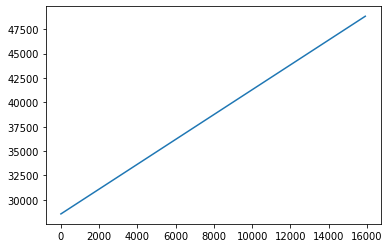

In [ ]:
plt.plot(start)

In [ ]:
close['close'].to_numpy()

array([ 9232. ,  9290.5,  9271.5, ..., 21372. , 21335. , 21417. ])

In [ ]:
lagy = 10
fut = 1
out = lag(pd.DataFrame(close), lagy)
out['target'] = btc['close'].shift(-fut)
out = out.iloc[:-fut]

In [ ]:
out

,close,close_lag0,close_lag1,close_lag2,close_lag3,close_lag4,close_lag5,close_lag6,close_lag7,close_lag8,close_lag9,target
5,9232.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9290.5
7,9290.5,9232.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9271.5
9,9271.5,9290.5,9232.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9185.5
12,9185.5,9271.5,9290.5,9232.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9217.5
17,9217.5,9185.5,9271.5,9290.5,9232.0,NaN,NaN,NaN,NaN,NaN,NaN,9248.0
...,...,...,...,...,...,...,...,...,...,...,...,...
39751,21413.0,21495.0,21188.0,21188.0,21225.0,21073.0,21039.0,20957.0,21108.0,21141.0,21124.0,21472.0
39754,21472.0,21413.0,21495.0,21188.0,21188.0,21225.0,21073.0,21039.0,20957.0,21108.0,21141.0,21458.0
39757,21458.0,21472.0,21413.0,21495.0,21188.0,21188.0,21225.0,21073.0,21039.0,20957.0,21108.0,21372.0
39760,21372.0,21458.0,21472.0,21413.0,21495.0,21188.0,21188.0,21225.0,21073.0,21039.0,20957.0,21335.0


In [ ]:
ins = out.iloc[lagy:].drop('target', axis = 1)
tar = out['target'].iloc[lagy:]
rfr = LinearRegression()
rfr.fit(ins.iloc[0:1000], tar.iloc[0:1000])
y_pred = rfr.predict(ins.iloc[1000:15000])

In [ ]:
from sklearn.metrics import mean_squared_error
target = tar.iloc[1000:15000].reset_index().drop('index', axis = 1)
np.sqrt(mean_squared_error(target, y_pred))

391.9730845776529

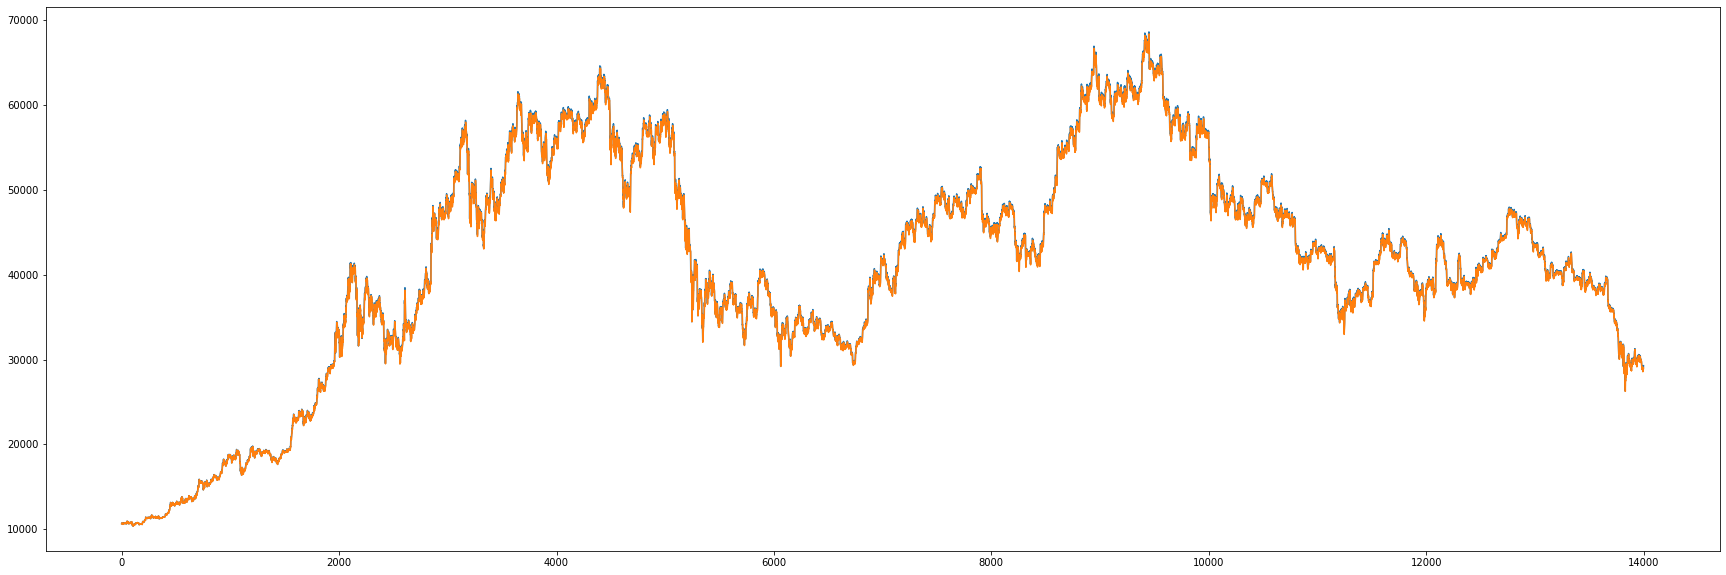

In [ ]:
plt.figure(figsize = (30,10))
plt.plot(target, label = 'target')
plt.plot(y_pred,label = 'prediction')
plt.savefig('prediction.pdf')

1085.6810720388494